In [1]:
## imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, precision_score
import matplotlib.pyplot as plt
# We will use the lightgbm python package. its advantages is that you can insert to the model
# lines with missing values. Another advantage is that categorical features can be handled with
# unique integers/floats and is much more faster than one-hot coding

In [2]:
## I saved the dataset to my computer. let's load the data observe it
filepath = r"C:\Projects\Deep Learning Academy\Click\data_click.csv"
data = pd.read_csv(filepath)
print(data.head(5))
print(data.columns)

     OpenDate FirstName LastName  Gender PreviousCancellations  \
0     9/14/16   Aurelia   Hursey  Female                     0   
1     9/17/16       Sid      Fye     NaN                     0   
2     9/13/16   Kathrin  Lizotte  Female                     0   
3     9/17/16   Jacinta    Ealey  Female                     0   
4  09/12/2016       Sal     Lupi    Male                     0   

  YearsAsCustomer  CustomerApproved AppointmentDate      AppointmentSlot  \
0       3-5 Years             False         9/25/16                  NaN   
1       0-1 Years             False         9/28/16  12:00 PM - 02:00 PM   
2    Over 5 Years             False         9/29/16  04:00 PM - 06:00 PM   
3       0-1 Years             False         9/27/16  10:00 AM - 12:00 PM   
4       1-3 Years             False      10/05/2016  02:00 PM - 04:00 PM   

   EngineerKey         TaskCategory                        Maintenance  \
0      1234490  Planned Maintenance  Premise maintenance with customer  

In [3]:
## check for non informative columns
# we will go over each column and observe whether the column holds informative data
# columns with non informative data will be dropped

## lets remove columns that are non-informative
print("Percentage of missing values in each column:")
print(pd.isnull(data).sum()/data.shape[0] * 100)

Percentage of missing values in each column:
OpenDate                  0.0
FirstName                 0.0
LastName                  0.0
Gender                   14.7
PreviousCancellations     0.0
YearsAsCustomer           0.0
CustomerApproved          0.0
AppointmentDate           0.0
AppointmentSlot          18.1
EngineerKey               0.0
TaskCategory              0.0
Maintenance               0.8
FixDescription           66.4
CustomerAge               0.0
PastVisits                0.0
Result                    0.0
dtype: float64


In [4]:
# 66.4% of the values in the FixDescription column are missing. Let's remove this column
data.drop(["FixDescription"], axis=1, inplace=True)

In [5]:
# We will concatenate the first and last name to a full name and see if there are customers that appear more than once
#  If there isn't, the column can be dropped
full_name = data["FirstName"] + str(" ") + data["LastName"]
print(full_name.value_counts().sort_values(ascending=False).head(10))

Selene Stott          1
Kendal Pua            1
Hiram Olivera         1
Luvenia Donegan       1
Halley Stolte         1
Maurita Budniewski    1
Gwyneth Guthridge     1
Art Linde             1
Sandy Mcbee           1
Mark Pruden           1
dtype: int64


In [6]:
# As we can see, each name appears only once, we will drop these columns (FirstName and LastName)
data.drop(["FirstName", "LastName"], axis=1, inplace=True)

Text(0,0.5,'Occurrences')

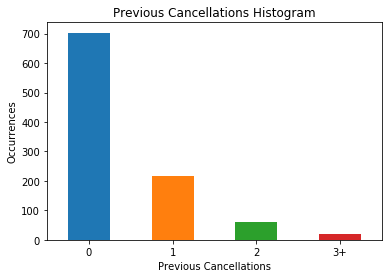

In [7]:
# examine PreviousCancellations
data["PreviousCancellations"].value_counts().plot(kind="bar", rot=0)
plt.title("Previous Cancellations Histogram")
plt.xlabel("Previous Cancellations")
plt.ylabel("Occurrences")

In [8]:
# We can learn from the bar graph above that most jobs haven't been cancelled before.
# There are 4 unique values. Obviously this column contains strings (due to 3+). Let's convert this column to integers
data["PreviousCancellations"] = pd.factorize(data["PreviousCancellations"])[0]

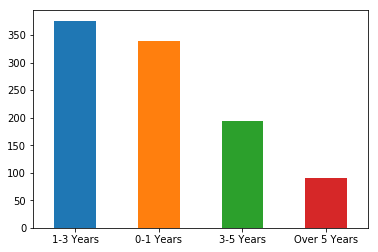

In [9]:
# examine YearsAsCustomer
data["YearsAsCustomer"].value_counts().plot(kind="bar", rot=0)

In [10]:
# The majority of the customers are using the company service up to 3 years.
# There are 4 unique values here as well. Let's convert this column to integers too
mapping = {'0-1 Years': 0, '1-3 Years': 1, "3-5 Years": 2, "Over 5 Years":3}
data["YearsAsCustomer"].replace(mapping, inplace=True)

In [11]:
# Let's extract features from the date columns that might influence the job completion and make our data invariant to the date
# The reason to be invariant to the date is because I don't want to be limited and consider only data records up till
# a certain date for the training data (and test my predictions on a future test data) but rather have more generalized
# features that will allow me to consider to my training data any possible record
# Let's add a new column specifying the number of jobs the engineer has on the appointment date
data["EngineerKey"] = pd.factorize(data["EngineerKey"])[0]
data.sort_values(by=["AppointmentDate", "EngineerKey"], inplace=True)
num_jobs_eng_per_date = data.groupby(['AppointmentDate', 'EngineerKey']).size()
data.set_index(['AppointmentDate', 'EngineerKey'], inplace=True)
data["num_jobs"] = num_jobs_eng_per_date
data.reset_index(inplace=True)

Text(0,0.5,'% incomplete jobs')

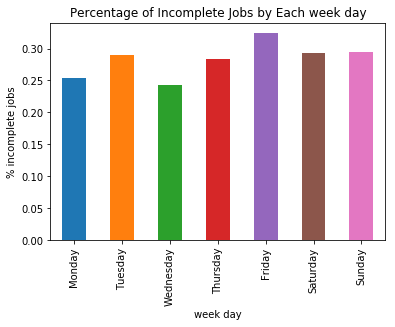

In [12]:
# Add a new column specifying the day of the week at which the job was appointed
data["day_of_week"] = pd.to_datetime(data["AppointmentDate"]).dt.day_name()

# check if there specific week days at which the jobs are tended to be incomplete
num_tot_jobs_per_week_day = data["day_of_week"].value_counts()
num_incomplete_week_day = data["Result"].groupby(data["day_of_week"]).sum()
percentage_incomplete_per_week_day = (num_incomplete_week_day/num_tot_jobs_per_week_day)
# re order from Monday to Sunday
reorder_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
percentage_incomplete_per_week_day = percentage_incomplete_per_week_day.reindex(reorder_list)
percentage_incomplete_per_week_day.plot(kind="bar")
plt.title("Percentage of Incomplete Jobs by Each week day")
plt.xlabel("week day")
plt.ylabel("% incomplete jobs")


In [13]:
# We can see that on Wednesday the probability to have an incomplete job is the lowest while on Friday it's the highest
# Assign the week days as integers instead of strings
data["day_of_week"] = pd.to_datetime(data["AppointmentDate"]).dt.dayofweek

In [14]:
# delete the date columns
data.drop(["AppointmentDate", "OpenDate"], axis=1, inplace=True)

Text(0,0.5,'% incomplete jobs')

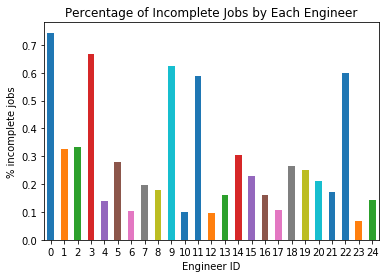

In [15]:
# check if there are engineers that usually don't get their job done
num_tot_jobs_per_eng = data["EngineerKey"].value_counts()
num_incomplete_per_eng = data["Result"].groupby(data["EngineerKey"]).sum()
percentage_incomplete_per_eng = num_incomplete_per_eng/num_tot_jobs_per_eng
percentage_incomplete_per_eng.plot(kind="bar", rot=0)
plt.title("Percentage of Incomplete Jobs by Each Engineer")
plt.xlabel("Engineer ID")
plt.ylabel("% incomplete jobs")

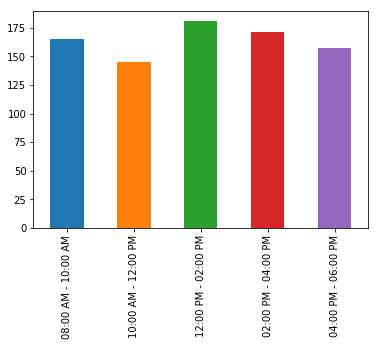

In [16]:
# We can learn from the bar graph above that there are more professional engineers than others

# examine YearsAsCustomer
appointment_slot =  data["AppointmentSlot"].value_counts()
reorder_list = ["08:00 AM - 10:00 AM", "10:00 AM - 12:00 PM", "12:00 PM - 02:00 PM",
                "02:00 PM - 04:00 PM", "04:00 PM - 06:00 PM"]
appointment_slot = appointment_slot.reindex(reorder_list)
appointment_slot.plot(kind="bar")


In [17]:
# There are 5 unique values here. Let's convert this column to integers
mapping = {'08:00 AM - 10:00 AM': 0, '10:00 AM - 12:00 PM': 1, "12:00 PM - 02:00 PM": 2,
           "02:00 PM - 04:00 PM": 3, "04:00 PM - 06:00 PM":4}
data["AppointmentSlot"].replace(mapping, inplace=True)

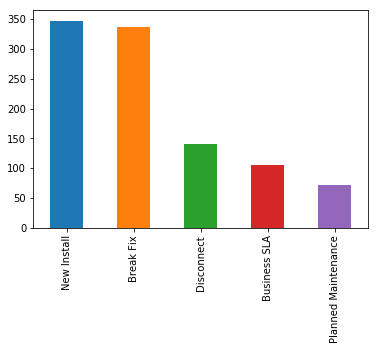

In [18]:
# check if there are tasks that often don't get done
data["TaskCategory"].value_counts().plot(kind="bar")

Text(0,0.5,'% incomplete jobs')

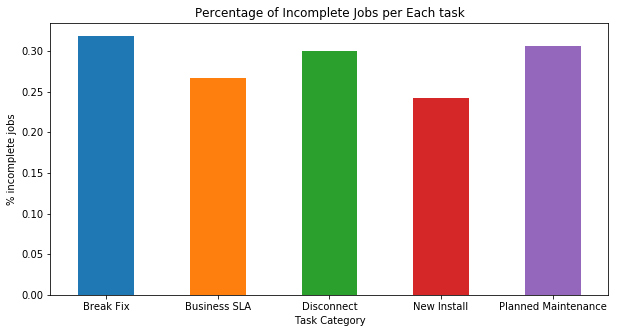

In [19]:
# There are five different task categories. Plot the percentage of failures for each task
plt.figure(figsize=(10,5))
temp_data = data[["TaskCategory", "Result"]]
num_tot_jobs_per_task = temp_data["TaskCategory"].value_counts()
num_incomplete_per_task = temp_data["Result"].groupby(data["TaskCategory"]).sum()
percentage_incomplete_per_task = num_incomplete_per_task/num_tot_jobs_per_task
percentage_incomplete_per_task.plot(kind="bar", rot=0)
plt.title("Percentage of Incomplete Jobs per Each task")
plt.xlabel("Task Category")
plt.ylabel("% incomplete jobs")

In [20]:
# It can be seen that break fix and planned maintenance are the most incomplete task categories while
# new install is the least incomplete task

# Examine the maintenance column
data["Maintenance"].value_counts()

Premise maintenance with customer    991
ResidenceType                          1
Name: Maintenance, dtype: int64

In [21]:
# This column holds 991 values which are the same. This column is not informative and therefore will be dropped
data.drop(["Maintenance"], axis=1, inplace=True)

Text(0,0.5,'Occurrences')

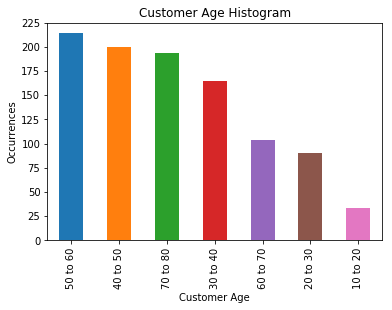

In [22]:
# Examine the CustomerAge column
data["CustomerAge"].value_counts().plot(kind="bar")
plt.title("Customer Age Histogram")
plt.xlabel("Customer Age")
plt.ylabel("Occurrences")


In [23]:
# convert the customer age to floats
data["CustomerAge"] = data["CustomerAge"].apply(lambda x: float(x[0:2])+5)

In [24]:
## lets check if the data is balanced
percentage_incomplete = (data["Result"].sum())/data.shape[0]
print("The percentage of incomplete jobs is: " + str(round(percentage_incomplete*100,1)) + "%")

The percentage of incomplete jobs is: 28.3%


In [25]:
# The data is somewhat unbalanced

# Convert the rest of the categorical columns to floats
categorical_cols = ["Gender", "CustomerApproved", "TaskCategory"]
for col in categorical_cols:
    data[col], levels  = pd.factorize(data[col], na_sentinel=-100)
data[data == -100] = np.nan

In [26]:
## Divide to features and target
y = data["Result"]
x = data.drop(["Result"], axis=1)

In [27]:
## Divide to train and test sets. We can shuffle the data because the date is not one of our features (date invariant)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42) #random_state for reproducing the results between runs
x_train = x_train.values
x_test = x_test.values

In [28]:
# create train data set for the lgb training model
lgb_train = lgb.Dataset(x_train, y_train)

In [29]:
# Specifying the parameters of the model and taking into consideration the unbalanced data
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {"binary_error"},
    'num_leaves': 3,
    'learning_rate': 0.04,
    'verbose': 0,
    "min_data_in_leaf":6,
    'scale_pos_weight':1 # handles with the unbalanced data. got best result with scale_pos_weight=1 which
                         # does not suggest that the data should be handled in unbalanced 
}

In [30]:
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000)

In [31]:
## The following is a function that predicts and evaluates the predictions of the model
def evaluate_prediction(x, ytrue, gbm, threshold=0.5):
    # The function evaluates the predictions of a given model
    # Inputs:
    # x - MxN numpy array of the features
    # ytrue - Mx1 numpy array of the targets
    # gbm - predictive model
    # threshold - The threshold for a prediction probability to be considered as class "1" (incomplete job)
    #
    # Outputs:
    # ypred - Mx1 numpy array of the predicted probabilities to have an incomplete job
    # accuracy - 1x1 of the accuracy of the model
    # conf_matrix - 2x2 of the confusion matrix of the model
    # conf_matrix[0,0] - true negatives
    # conf_matrix[1,0] - false negatives
    # conf_matrix[0,1] - false positives
    # conf_matrix[1,1] - true positives
    # precision - 1x1 of the precision of the model
    ypred = gbm.predict(x)

    # binarize the predictions based on a threshold (default of 50%). If the probability to have an incomplete job is greater
    # than the threshold, it will be considered as a prediction of an incomplete job
    ypred_binary = ypred > threshold
    accuracy = (sum(ypred_binary == ytrue)) / ytrue.shape[0]
    conf_matrix = confusion_matrix(ytrue, ypred_binary)
    precision = precision_score(ytrue, ypred_binary, average="binary")

    return ypred, accuracy, conf_matrix, precision


In [32]:
## prediction of the test set
ypred_test, accuracy_test, conf_matrix_test, precision_test = evaluate_prediction(x_test, y_test, gbm)

In [33]:
# We will print some results of the prediction of the test set
# 10 values of the true test set
print("First 10 values of the true test set")
print(y_test[:10].ravel())
# "ypred_test" holds the probability to have an incomplete job.
# 10 values of the probability to have an incomplete job
print("\n First 10 values of the probability to have an incomplete job")
np.set_printoptions(precision=2, suppress=True)
print(ypred_test[:10])

First 10 values of the true test set
[0 1 0 0 0 0 0 0 1 1]

 First 10 values of the probability to have an incomplete job
[0.18 0.64 0.   0.01 0.   0.   0.04 0.06 0.87 0.15]


In [34]:
# print the accuracy of the test set
print("The prediction accuracy on the test set is: " + str(round(accuracy_test*100,1)) + str("%"))
# print the confusion matrix
print("The confusion matrix on the test set is: ")
print(conf_matrix_test)
# We could adjust the parameter "scale_pos_weight" to get more true positives - it depends on what is
# important for us in the prediction
print("The precision on the test set is: " + str(round(precision_test*100,1)) + str("%"))


The prediction accuracy on the test set is: 85.3%
The confusion matrix on the test set is: 
[[202  13]
 [ 31  54]]
The precision on the test set is: 80.6%
